## CSC-180 Project 1
##### By: Derek Chen, Nicolas Gueliemo, Xai Yang, Katrina Yu

### Imports & Provided Functions from Lab

In [10]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import random
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import os
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        print('CLASS')
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        print('REG')
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

# Function to plot results
def plot(results):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for activation in results['Activation'].unique():
        subset = results[results['Activation'] == activation]
        ax.plot(subset['Neurons'].astype(str), subset['RMSE'], marker='o', label=activation)

    ax.set_title('Model Performance by Activation Function')
    ax.set_xlabel('Layer Configuration (Neurons)')
    ax.set_ylabel('RMSE')
    ax.legend(title='Activation Function')
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.show()

def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    plt.plot(t['pred'].tolist(), label='Prediction', color='orange')
    plt.plot(t['y'].tolist(), label='Expected', color='blue')
    plt.ylabel('output')
    plt.legend()
    plt.show()
    
# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low


### Original Code
#### Includes:
- Spliting Data into Training & Testing for Models
- Using TF-IDF to extract features
- Implementing Early Stopping for training with TensorFlow
- Showing inital RMSE

In [3]:
# Original Code
# Author: Nicolas Gugliemo, Katrina Yu
# Date: 9/16/2024
# Project: Project 1 Yelp Business Rating Prediction using Tensorflow
# Goal: Predict Business's stars rating... 

# Set path and preprocess for functions
path = "./yelp_dataset/"
preprocess = True

#Set paths for JSON
review_Path = os.path.join(path,"yelp_academic_dataset_review.json")
business_Path = os.path.join(path,"yelp_academic_dataset_business.json")

# Read JSON data and drop businesses with less than 20 reviews
review_df = pd.read_json(review_Path, lines=True, nrows = 100000)
all_business_df = pd.read_json(business_Path, lines=True, nrows = 100000)
business_df = all_business_df[all_business_df['review_count'] >= 20]

# You may use the following code to group ALL the reviews by each business and create a new
# dataframe, where each line is a business with all its reviews aggregated together. From there,
# you then use tfidfVectorzier to obtain TFIDF representation for each business.
df_review_agg = review_df.groupby('business_id')['text'].sum()
df_ready_to_be_sent_to_sklearn = pd.DataFrame({'business_id': df_review_agg.index,
                                               'all_reviews': df_review_agg.values,})

# Create table with ID, stars, and all reviews in one table then change 'stars' since this is already a col on tfidf
business_subset = business_df[['business_id', 'stars']]
business_names = business_df[['name', 'business_id']]
review_subset = df_ready_to_be_sent_to_sklearn[['business_id', 'all_reviews']]
merged_df = pd.merge(business_subset, review_subset, on='business_id', how='inner')
merged_df.rename(columns={'stars': 'stars_for_model'}, inplace=True)

# Initialize the tfidf Vectorizer and set max features and stop words
tfidf = TfidfVectorizer(max_features=4000,stop_words="english")

# Transform all_reviews and turn into a matrix
tfidf_matrix = tfidf.fit_transform(merged_df['all_reviews'])

# Turn the matrix into a dataframe where the cols are all the words. Then add the stars into the dataframe for model to use and use to_xy for tensorflow to read
tfidf_df = pd.DataFrame(data = tfidf_matrix.toarray(), columns = tfidf.get_feature_names_out())
tfidf_df = pd.concat([merged_df['stars_for_model'], tfidf_df] , axis=1)
x,y = to_xy(tfidf_df,'stars_for_model')

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

# Run the model 5 times to ensure best model is found
i = 0
while (i < 5):
    model = Sequential()
    model.add(Dense(100, input_dim=x.shape[1], activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(50, input_dim=x.shape[1], activation='relu')) 
    model.add(Dropout(0.1))
    model.add(Dense(25, input_dim=x.shape[1], activation='relu')) 
    model.add(Dense(1, activation='linear'))

    adam = optimizers.Adam(learning_rate=0.001, beta_1=0.999, beta_2=0.999, epsilon=None, amsgrad=False)
    model.compile(loss='mean_squared_error', optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto')
    checkpointer = ModelCheckpoint(filepath="dnn/yelp.keras", verbose=0, save_best_only=True) # save best model

    # batch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32.
    model.fit(x_train, y_train, validation_data = (x_test, y_test), batch_size= 32, callbacks=[monitor,checkpointer], verbose=2, epochs=1000)
    i = i+1

model.load_weights('dnn/yelp.keras') # load weights from best model

# Predict and measure RMSE
pred = model.predict(x_test)

score = np.sqrt(metrics.mean_squared_error(pred, y_test))
print("Score (RMSE) without Rounding: {}".format(score))

# Rounding up predicted values to .5
for i in pred:
    if i[0] < 5:
        i[0] = round(i[0]*2)/2
    if i[0] > 5:
        i[0] = 5

score = np.sqrt(metrics.mean_squared_error(pred, y_test))
print("Score (RMSE) with Rounding: {}".format(score))


REG


c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 7s - 52ms/step - loss: 2.4856 - val_loss: 0.4643
Epoch 2/1000
136/136 - 1s - 8ms/step - loss: 0.4008 - val_loss: 0.3457
Epoch 3/1000
136/136 - 1s - 7ms/step - loss: 0.2590 - val_loss: 0.3702
Epoch 4/1000
136/136 - 1s - 8ms/step - loss: 0.2251 - val_loss: 0.3783
Epoch 5/1000
136/136 - 1s - 7ms/step - loss: 0.1951 - val_loss: 0.3904
Epoch 6/1000
136/136 - 1s - 7ms/step - loss: 0.1680 - val_loss: 0.4042
Epoch 7/1000
136/136 - 1s - 9ms/step - loss: 0.1402 - val_loss: 0.4180
Epoch 8/1000
136/136 - 1s - 9ms/step - loss: 0.1288 - val_loss: 0.4352
Epoch 9/1000
136/136 - 1s - 6ms/step - loss: 0.1125 - val_loss: 0.4288
Epoch 10/1000
136/136 - 1s - 7ms/step - loss: 0.0979 - val_loss: 0.4314
Epoch 11/1000
136/136 - 1s - 7ms/step - loss: 0.0881 - val_loss: 0.4365
Epoch 12/1000
136/136 - 1s - 7ms/step - loss: 0.0846 - val_loss: 0.4491
Epoch 12: early stopping
Epoch 1/1000
136/136 - 4s - 30ms/step - loss: 2.9459 - val_loss: 0.5372
Epoch 2/1000
136/136 - 1s - 8ms/step - loss: 0.

### Finding the best Model with the best RMSE
Testing with different combinations & numbers of the following:
- Activation: relu, sigmoid, tanh
- Number of layers and neuron count for each layer
- Optimizer: adam and sgd.

### & Displaying 5 different random businesses actual stars & predicted stars Using the best Model from above

REG


c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 3s - 23ms/step - loss: 2.9939 - val_loss: 0.6216
Epoch 2/1000
136/136 - 1s - 7ms/step - loss: 0.4990 - val_loss: 0.3578
Epoch 3/1000
136/136 - 1s - 8ms/step - loss: 0.3289 - val_loss: 0.3659
Epoch 4/1000
136/136 - 1s - 10ms/step - loss: 0.2639 - val_loss: 0.3694
Epoch 5/1000
136/136 - 1s - 7ms/step - loss: 0.2271 - val_loss: 0.3934
Epoch 6/1000
136/136 - 1s - 7ms/step - loss: 0.2123 - val_loss: 0.4018
Epoch 7/1000
136/136 - 1s - 7ms/step - loss: 0.1965 - val_loss: 0.4140
Epoch 8/1000
136/136 - 1s - 7ms/step - loss: 0.1776 - val_loss: 0.4305
Epoch 9/1000
136/136 - 1s - 8ms/step - loss: 0.1656 - val_loss: 0.4279
Epoch 10/1000
136/136 - 1s - 7ms/step - loss: 0.1507 - val_loss: 0.4352
Epoch 11/1000
136/136 - 1s - 7ms/step - loss: 0.1450 - val_loss: 0.4476
Epoch 12/1000
136/136 - 1s - 7ms/step - loss: 0.1357 - val_loss: 0.4396
Epoch 12: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
[[3.0426056]
 [3.1396081]
 [2.6131082]
 ...
 [4.6907682]
 [3.7122695]
 [3.82247

c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 2s - 13ms/step - loss: 1.4825 - val_loss: 0.6198
Epoch 2/1000
136/136 - 1s - 5ms/step - loss: 0.7099 - val_loss: 0.5992
Epoch 3/1000
136/136 - 1s - 5ms/step - loss: 0.6505 - val_loss: 0.5617
Epoch 4/1000
136/136 - 1s - 5ms/step - loss: 0.6156 - val_loss: 0.5088
Epoch 5/1000
136/136 - 1s - 4ms/step - loss: 0.5633 - val_loss: 0.4620
Epoch 6/1000
136/136 - 1s - 4ms/step - loss: 0.5128 - val_loss: 0.4142
Epoch 7/1000
136/136 - 1s - 4ms/step - loss: 0.4507 - val_loss: 0.3737
Epoch 8/1000
136/136 - 1s - 4ms/step - loss: 0.4069 - val_loss: 0.3523
Epoch 9/1000
136/136 - 1s - 4ms/step - loss: 0.3804 - val_loss: 0.3352
Epoch 10/1000
136/136 - 1s - 4ms/step - loss: 0.3626 - val_loss: 0.3253
Epoch 11/1000
136/136 - 1s - 4ms/step - loss: 0.3435 - val_loss: 0.3170
Epoch 12/1000
136/136 - 1s - 4ms/step - loss: 0.3379 - val_loss: 0.3163
Epoch 13/1000
136/136 - 1s - 4ms/step - loss: 0.3280 - val_loss: 0.3144
Epoch 14/1000
136/136 - 1s - 4ms/step - loss: 0.3097 - val_loss: 0.3232
Epoch 15/1000

c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 5s - 34ms/step - loss: 2.7650 - val_loss: 0.5235
Epoch 2/1000
136/136 - 1s - 8ms/step - loss: 0.5912 - val_loss: 0.3498
Epoch 3/1000
136/136 - 1s - 10ms/step - loss: 0.4321 - val_loss: 0.3564
Epoch 4/1000
136/136 - 1s - 6ms/step - loss: 0.3891 - val_loss: 0.3845
Epoch 5/1000
136/136 - 1s - 7ms/step - loss: 0.3354 - val_loss: 0.3746
Epoch 6/1000
136/136 - 1s - 7ms/step - loss: 0.3138 - val_loss: 0.3915
Epoch 7/1000
136/136 - 1s - 7ms/step - loss: 0.2835 - val_loss: 0.4064
Epoch 8/1000
136/136 - 1s - 7ms/step - loss: 0.2637 - val_loss: 0.4047
Epoch 9/1000
136/136 - 1s - 7ms/step - loss: 0.2521 - val_loss: 0.4139
Epoch 10/1000
136/136 - 1s - 7ms/step - loss: 0.2297 - val_loss: 0.3985
Epoch 11/1000
136/136 - 1s - 7ms/step - loss: 0.2187 - val_loss: 0.3984
Epoch 12/1000
136/136 - 1s - 7ms/step - loss: 0.2230 - val_loss: 0.4047
Epoch 12: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
[[3.0015905]
 [3.325656 ]
 [2.5321898]
 ...
 [4.7615604]
 [3.4873369]
 [3.81487

c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 3s - 20ms/step - loss: 1.6800 - val_loss: 0.6309
Epoch 2/1000
136/136 - 1s - 4ms/step - loss: 0.7777 - val_loss: 0.6453
Epoch 3/1000
136/136 - 1s - 6ms/step - loss: 0.7445 - val_loss: 0.5969
Epoch 4/1000
136/136 - 1s - 5ms/step - loss: 0.6939 - val_loss: 0.5678
Epoch 5/1000
136/136 - 1s - 7ms/step - loss: 0.6474 - val_loss: 0.5126
Epoch 6/1000
136/136 - 1s - 5ms/step - loss: 0.5818 - val_loss: 0.4555
Epoch 7/1000
136/136 - 1s - 6ms/step - loss: 0.5025 - val_loss: 0.4667
Epoch 8/1000
136/136 - 1s - 5ms/step - loss: 0.4427 - val_loss: 0.3504
Epoch 9/1000
136/136 - 1s - 4ms/step - loss: 0.4089 - val_loss: 0.3604
Epoch 10/1000
136/136 - 1s - 5ms/step - loss: 0.3782 - val_loss: 0.3226
Epoch 11/1000
136/136 - 1s - 6ms/step - loss: 0.3486 - val_loss: 0.3102
Epoch 12/1000
136/136 - 1s - 5ms/step - loss: 0.3459 - val_loss: 0.3512
Epoch 13/1000
136/136 - 1s - 4ms/step - loss: 0.3361 - val_loss: 0.3475
Epoch 14/1000
136/136 - 1s - 4ms/step - loss: 0.3245 - val_loss: 0.2968


c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 6s - 41ms/step - loss: 2.3352 - val_loss: 0.4093
Epoch 2/1000
136/136 - 1s - 10ms/step - loss: 0.4752 - val_loss: 0.3477
Epoch 3/1000
136/136 - 1s - 10ms/step - loss: 0.3481 - val_loss: 0.3613
Epoch 4/1000
136/136 - 1s - 10ms/step - loss: 0.2987 - val_loss: 0.3760
Epoch 5/1000
136/136 - 2s - 11ms/step - loss: 0.2652 - val_loss: 0.4041
Epoch 6/1000
136/136 - 1s - 11ms/step - loss: 0.2409 - val_loss: 0.4051
Epoch 7/1000
136/136 - 1s - 9ms/step - loss: 0.2158 - val_loss: 0.3970
Epoch 8/1000
136/136 - 1s - 10ms/step - loss: 0.2019 - val_loss: 0.4060
Epoch 9/1000
136/136 - 1s - 11ms/step - loss: 0.1839 - val_loss: 0.4189
Epoch 10/1000
136/136 - 3s - 21ms/step - loss: 0.1680 - val_loss: 0.4192
Epoch 11/1000
136/136 - 2s - 12ms/step - loss: 0.1742 - val_loss: 0.4172
Epoch 12/1000
136/136 - 2s - 11ms/step - loss: 0.1619 - val_loss: 0.4320
Epoch 12: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
[[2.582122 ]
 [3.2193518]
 [2.5418217]
 ...
 [4.68026  ]
 [3.7353792]


c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 2s - 16ms/step - loss: 1.5618 - val_loss: 0.6347
Epoch 2/1000
136/136 - 1s - 5ms/step - loss: 0.7780 - val_loss: 0.6617
Epoch 3/1000
136/136 - 1s - 7ms/step - loss: 0.7156 - val_loss: 0.5284
Epoch 4/1000
136/136 - 1s - 7ms/step - loss: 0.6301 - val_loss: 0.4685
Epoch 5/1000
136/136 - 1s - 7ms/step - loss: 0.5518 - val_loss: 0.4248
Epoch 6/1000
136/136 - 1s - 7ms/step - loss: 0.4846 - val_loss: 0.3692
Epoch 7/1000
136/136 - 1s - 8ms/step - loss: 0.4297 - val_loss: 0.3446
Epoch 8/1000
136/136 - 1s - 9ms/step - loss: 0.4081 - val_loss: 0.3303
Epoch 9/1000
136/136 - 1s - 6ms/step - loss: 0.3847 - val_loss: 0.3618
Epoch 10/1000
136/136 - 1s - 6ms/step - loss: 0.3773 - val_loss: 0.3156
Epoch 11/1000
136/136 - 1s - 6ms/step - loss: 0.3550 - val_loss: 0.3417
Epoch 12/1000
136/136 - 1s - 7ms/step - loss: 0.3364 - val_loss: 0.3192
Epoch 13/1000
136/136 - 1s - 7ms/step - loss: 0.3266 - val_loss: 0.3194
Epoch 14/1000
136/136 - 1s - 8ms/step - loss: 0.3187 - val_loss: 0.3488


c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 7s - 48ms/step - loss: 2.1896 - val_loss: 0.3577
Epoch 2/1000
136/136 - 1s - 9ms/step - loss: 0.3523 - val_loss: 0.3509
Epoch 3/1000
136/136 - 1s - 11ms/step - loss: 0.2572 - val_loss: 0.3903
Epoch 4/1000
136/136 - 1s - 8ms/step - loss: 0.2154 - val_loss: 0.4304
Epoch 5/1000
136/136 - 1s - 7ms/step - loss: 0.1806 - val_loss: 0.3927
Epoch 6/1000
136/136 - 1s - 7ms/step - loss: 0.1600 - val_loss: 0.3853
Epoch 7/1000
136/136 - 1s - 8ms/step - loss: 0.1318 - val_loss: 0.4141
Epoch 8/1000
136/136 - 1s - 9ms/step - loss: 0.1194 - val_loss: 0.3920
Epoch 9/1000
136/136 - 1s - 9ms/step - loss: 0.1047 - val_loss: 0.4123
Epoch 10/1000
136/136 - 1s - 10ms/step - loss: 0.1045 - val_loss: 0.3924
Epoch 11/1000
136/136 - 1s - 9ms/step - loss: 0.0959 - val_loss: 0.3861
Epoch 12/1000
136/136 - 1s - 9ms/step - loss: 0.0924 - val_loss: 0.3892
Epoch 12: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
[[3.298763 ]
 [3.4198751]
 [2.6003773]
 ...
 [4.8682256]
 [3.8714185]
 [4.1225

c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 2s - 18ms/step - loss: 1.7380 - val_loss: 0.6319
Epoch 2/1000
136/136 - 1s - 6ms/step - loss: 0.7296 - val_loss: 0.6201
Epoch 3/1000
136/136 - 1s - 5ms/step - loss: 0.6911 - val_loss: 0.5837
Epoch 4/1000
136/136 - 1s - 5ms/step - loss: 0.6379 - val_loss: 0.5452
Epoch 5/1000
136/136 - 1s - 5ms/step - loss: 0.5874 - val_loss: 0.4819
Epoch 6/1000
136/136 - 2s - 12ms/step - loss: 0.5108 - val_loss: 0.4255
Epoch 7/1000
136/136 - 1s - 7ms/step - loss: 0.4436 - val_loss: 0.3814
Epoch 8/1000
136/136 - 1s - 5ms/step - loss: 0.3977 - val_loss: 0.3342
Epoch 9/1000
136/136 - 1s - 6ms/step - loss: 0.3640 - val_loss: 0.3180
Epoch 10/1000
136/136 - 1s - 9ms/step - loss: 0.3570 - val_loss: 0.3128
Epoch 11/1000
136/136 - 1s - 9ms/step - loss: 0.3378 - val_loss: 0.3306
Epoch 12/1000
136/136 - 1s - 5ms/step - loss: 0.3161 - val_loss: 0.3364
Epoch 13/1000
136/136 - 1s - 9ms/step - loss: 0.3104 - val_loss: 0.4389
Epoch 14/1000
136/136 - 1s - 8ms/step - loss: 0.2928 - val_loss: 0.2949

c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 8s - 62ms/step - loss: 3.1859 - val_loss: 0.4153
Epoch 2/1000
136/136 - 2s - 12ms/step - loss: 0.6590 - val_loss: 0.4904
Epoch 3/1000
136/136 - 2s - 13ms/step - loss: 0.4854 - val_loss: 0.3576
Epoch 4/1000
136/136 - 2s - 11ms/step - loss: 0.4080 - val_loss: 0.4563
Epoch 5/1000
136/136 - 1s - 11ms/step - loss: 0.3742 - val_loss: 0.5103
Epoch 6/1000
136/136 - 2s - 12ms/step - loss: 0.3288 - val_loss: 0.4028
Epoch 7/1000
136/136 - 1s - 11ms/step - loss: 0.3156 - val_loss: 0.5104
Epoch 8/1000
136/136 - 2s - 11ms/step - loss: 0.2941 - val_loss: 0.4479
Epoch 9/1000
136/136 - 2s - 11ms/step - loss: 0.2604 - val_loss: 0.3476
Epoch 10/1000
136/136 - 1s - 11ms/step - loss: 0.2501 - val_loss: 0.4002
Epoch 11/1000
136/136 - 2s - 11ms/step - loss: 0.2469 - val_loss: 0.3703
Epoch 12/1000
136/136 - 1s - 10ms/step - loss: 0.2364 - val_loss: 0.4750
Epoch 13/1000
136/136 - 2s - 11ms/step - loss: 0.2241 - val_loss: 0.3525
Epoch 14/1000
136/136 - 2s - 11ms/step - loss: 0.2055 - val_

c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 2s - 16ms/step - loss: 1.4694 - val_loss: 0.6631
Epoch 2/1000
136/136 - 1s - 6ms/step - loss: 0.7923 - val_loss: 0.6203
Epoch 3/1000
136/136 - 1s - 6ms/step - loss: 0.7444 - val_loss: 0.6015
Epoch 4/1000
136/136 - 1s - 5ms/step - loss: 0.6791 - val_loss: 0.4979
Epoch 5/1000
136/136 - 1s - 5ms/step - loss: 0.5678 - val_loss: 0.5223
Epoch 6/1000
136/136 - 1s - 7ms/step - loss: 0.4791 - val_loss: 0.4710
Epoch 7/1000
136/136 - 1s - 8ms/step - loss: 0.4254 - val_loss: 0.4002
Epoch 8/1000
136/136 - 1s - 10ms/step - loss: 0.4142 - val_loss: 0.3752
Epoch 9/1000
136/136 - 1s - 5ms/step - loss: 0.3951 - val_loss: 0.3058
Epoch 10/1000
136/136 - 1s - 7ms/step - loss: 0.3711 - val_loss: 0.3524
Epoch 11/1000
136/136 - 1s - 6ms/step - loss: 0.3428 - val_loss: 0.3016
Epoch 12/1000
136/136 - 1s - 7ms/step - loss: 0.3351 - val_loss: 0.3989
Epoch 13/1000
136/136 - 2s - 13ms/step - loss: 0.3262 - val_loss: 0.2946
Epoch 14/1000
136/136 - 1s - 9ms/step - loss: 0.3098 - val_loss: 0.387

c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 4s - 32ms/step - loss: 1.8836 - val_loss: 0.6117
Epoch 2/1000
136/136 - 1s - 7ms/step - loss: 0.7287 - val_loss: 0.5552
Epoch 3/1000
136/136 - 1s - 7ms/step - loss: 0.6497 - val_loss: 0.4971
Epoch 4/1000
136/136 - 1s - 7ms/step - loss: 0.5793 - val_loss: 0.4306
Epoch 5/1000
136/136 - 1s - 8ms/step - loss: 0.5097 - val_loss: 0.3762
Epoch 6/1000
136/136 - 1s - 8ms/step - loss: 0.4398 - val_loss: 0.3386
Epoch 7/1000
136/136 - 1s - 7ms/step - loss: 0.3868 - val_loss: 0.3188
Epoch 8/1000
136/136 - 1s - 7ms/step - loss: 0.3541 - val_loss: 0.3046
Epoch 9/1000
136/136 - 1s - 7ms/step - loss: 0.3451 - val_loss: 0.2968
Epoch 10/1000
136/136 - 1s - 7ms/step - loss: 0.3158 - val_loss: 0.2967
Epoch 11/1000
136/136 - 1s - 7ms/step - loss: 0.3148 - val_loss: 0.2905
Epoch 12/1000
136/136 - 1s - 7ms/step - loss: 0.2820 - val_loss: 0.3031
Epoch 13/1000
136/136 - 1s - 7ms/step - loss: 0.2751 - val_loss: 0.2917
Epoch 14/1000
136/136 - 1s - 7ms/step - loss: 0.2651 - val_loss: 0.2903
Epoch 15/1000

c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 2s - 12ms/step - loss: 1.0562 - val_loss: 0.6460
Epoch 2/1000
136/136 - 1s - 5ms/step - loss: 0.7715 - val_loss: 0.6494
Epoch 3/1000
136/136 - 1s - 5ms/step - loss: 0.7625 - val_loss: 0.6469
Epoch 4/1000
136/136 - 1s - 4ms/step - loss: 0.7520 - val_loss: 0.6582
Epoch 5/1000
136/136 - 1s - 5ms/step - loss: 0.7544 - val_loss: 0.6472
Epoch 6/1000
136/136 - 1s - 9ms/step - loss: 0.7379 - val_loss: 0.6455
Epoch 7/1000
136/136 - 1s - 9ms/step - loss: 0.7411 - val_loss: 0.6467
Epoch 8/1000
136/136 - 1s - 7ms/step - loss: 0.7436 - val_loss: 0.6483
Epoch 9/1000
136/136 - 1s - 6ms/step - loss: 0.7306 - val_loss: 0.6485
Epoch 10/1000
136/136 - 1s - 4ms/step - loss: 0.7215 - val_loss: 0.6742
Epoch 11/1000
136/136 - 1s - 8ms/step - loss: 0.7298 - val_loss: 0.6562
Epoch 11: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
[[3.6196713]
 [3.618407 ]
 [3.6182306]
 ...
 [3.6186597]
 [3.6196847]
 [3.6199243]]
Score (RMSE): 0.8034543395042419


c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 7s - 51ms/step - loss: 4.1153 - val_loss: 0.7370
Epoch 2/1000
136/136 - 1s - 8ms/step - loss: 0.8500 - val_loss: 0.6446
Epoch 3/1000
136/136 - 1s - 7ms/step - loss: 0.8359 - val_loss: 0.6456
Epoch 4/1000
136/136 - 1s - 7ms/step - loss: 0.8364 - val_loss: 0.6461
Epoch 5/1000
136/136 - 1s - 8ms/step - loss: 0.8108 - val_loss: 0.6417
Epoch 6/1000
136/136 - 1s - 8ms/step - loss: 0.8152 - val_loss: 0.6393
Epoch 7/1000
136/136 - 1s - 8ms/step - loss: 0.8093 - val_loss: 0.6310
Epoch 8/1000
136/136 - 1s - 7ms/step - loss: 0.7815 - val_loss: 0.6042
Epoch 9/1000
136/136 - 1s - 8ms/step - loss: 0.7344 - val_loss: 0.4995
Epoch 10/1000
136/136 - 1s - 7ms/step - loss: 0.5361 - val_loss: 0.3494
Epoch 11/1000
136/136 - 1s - 7ms/step - loss: 0.4235 - val_loss: 0.3174
Epoch 12/1000
136/136 - 1s - 8ms/step - loss: 0.3804 - val_loss: 0.2985
Epoch 13/1000
136/136 - 1s - 7ms/step - loss: 0.3571 - val_loss: 0.2935
Epoch 14/1000
136/136 - 1s - 8ms/step - loss: 0.3470 - val_loss: 0.2893


c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 2s - 15ms/step - loss: 1.1851 - val_loss: 0.6467
Epoch 2/1000
136/136 - 1s - 6ms/step - loss: 0.7859 - val_loss: 0.6468
Epoch 3/1000
136/136 - 1s - 6ms/step - loss: 0.7858 - val_loss: 0.6458
Epoch 4/1000
136/136 - 1s - 4ms/step - loss: 0.7729 - val_loss: 0.6485
Epoch 5/1000
136/136 - 1s - 5ms/step - loss: 0.7453 - val_loss: 0.6536
Epoch 6/1000
136/136 - 1s - 5ms/step - loss: 0.7481 - val_loss: 0.6573
Epoch 7/1000
136/136 - 1s - 5ms/step - loss: 0.7664 - val_loss: 0.6471
Epoch 8/1000
136/136 - 1s - 4ms/step - loss: 0.7448 - val_loss: 0.6530
Epoch 9/1000
136/136 - 1s - 4ms/step - loss: 0.7412 - val_loss: 0.6467
Epoch 10/1000
136/136 - 1s - 4ms/step - loss: 0.7323 - val_loss: 0.6456
Epoch 11/1000
136/136 - 1s - 6ms/step - loss: 0.7410 - val_loss: 0.6492
Epoch 12/1000
136/136 - 1s - 6ms/step - loss: 0.7330 - val_loss: 0.6464
Epoch 13/1000
136/136 - 1s - 11ms/step - loss: 0.7312 - val_loss: 0.6456
Epoch 14/1000
136/136 - 1s - 10ms/step - loss: 0.7340 - val_loss: 0.646

c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 8s - 56ms/step - loss: 1.2855 - val_loss: 0.6411
Epoch 2/1000
136/136 - 2s - 13ms/step - loss: 0.7919 - val_loss: 0.6360
Epoch 3/1000
136/136 - 2s - 11ms/step - loss: 0.7591 - val_loss: 0.6051
Epoch 4/1000
136/136 - 2s - 12ms/step - loss: 0.6931 - val_loss: 0.5023
Epoch 5/1000
136/136 - 2s - 12ms/step - loss: 0.5105 - val_loss: 0.3276
Epoch 6/1000
136/136 - 2s - 13ms/step - loss: 0.3908 - val_loss: 0.3012
Epoch 7/1000
136/136 - 3s - 24ms/step - loss: 0.3510 - val_loss: 0.2938
Epoch 8/1000
136/136 - 2s - 16ms/step - loss: 0.3232 - val_loss: 0.2914
Epoch 9/1000
136/136 - 2s - 14ms/step - loss: 0.3010 - val_loss: 0.2895
Epoch 10/1000
136/136 - 2s - 13ms/step - loss: 0.2757 - val_loss: 0.3015
Epoch 11/1000
136/136 - 2s - 12ms/step - loss: 0.2655 - val_loss: 0.3015
Epoch 12/1000
136/136 - 2s - 12ms/step - loss: 0.2574 - val_loss: 0.2926
Epoch 13/1000
136/136 - 2s - 13ms/step - loss: 0.2419 - val_loss: 0.2969
Epoch 14/1000
136/136 - 2s - 15ms/step - loss: 0.2390 - val_

c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 4s - 26ms/step - loss: 0.9211 - val_loss: 0.6470
Epoch 2/1000
136/136 - 1s - 7ms/step - loss: 0.7688 - val_loss: 0.6493
Epoch 3/1000
136/136 - 1s - 8ms/step - loss: 0.7631 - val_loss: 0.6483
Epoch 4/1000
136/136 - 1s - 10ms/step - loss: 0.7645 - val_loss: 0.6459
Epoch 5/1000
136/136 - 1s - 8ms/step - loss: 0.7488 - val_loss: 0.6499
Epoch 6/1000
136/136 - 2s - 13ms/step - loss: 0.7614 - val_loss: 0.6464
Epoch 7/1000
136/136 - 2s - 15ms/step - loss: 0.7354 - val_loss: 0.6706
Epoch 8/1000
136/136 - 1s - 7ms/step - loss: 0.7433 - val_loss: 0.6550
Epoch 9/1000
136/136 - 1s - 8ms/step - loss: 0.7394 - val_loss: 0.6488
Epoch 10/1000
136/136 - 1s - 7ms/step - loss: 0.7444 - val_loss: 0.6490
Epoch 11/1000
136/136 - 1s - 8ms/step - loss: 0.7351 - val_loss: 0.6822
Epoch 12/1000
136/136 - 1s - 9ms/step - loss: 0.7364 - val_loss: 0.6458
Epoch 13/1000
136/136 - 1s - 9ms/step - loss: 0.7441 - val_loss: 0.6463
Epoch 14/1000
136/136 - 1s - 9ms/step - loss: 0.7370 - val_loss: 0.64

c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 10s - 73ms/step - loss: 1.1477 - val_loss: 0.6386
Epoch 2/1000
136/136 - 1s - 10ms/step - loss: 0.7455 - val_loss: 0.5970
Epoch 3/1000
136/136 - 1s - 9ms/step - loss: 0.6447 - val_loss: 0.4411
Epoch 4/1000
136/136 - 2s - 15ms/step - loss: 0.4354 - val_loss: 0.3182
Epoch 5/1000
136/136 - 1s - 9ms/step - loss: 0.3525 - val_loss: 0.3036
Epoch 6/1000
136/136 - 1s - 9ms/step - loss: 0.3181 - val_loss: 0.2950
Epoch 7/1000
136/136 - 1s - 9ms/step - loss: 0.3051 - val_loss: 0.2850
Epoch 8/1000
136/136 - 1s - 8ms/step - loss: 0.2776 - val_loss: 0.2862
Epoch 9/1000
136/136 - 1s - 7ms/step - loss: 0.2603 - val_loss: 0.2870
Epoch 10/1000
136/136 - 1s - 9ms/step - loss: 0.2432 - val_loss: 0.2867
Epoch 11/1000
136/136 - 1s - 10ms/step - loss: 0.2320 - val_loss: 0.2882
Epoch 12/1000
136/136 - 2s - 12ms/step - loss: 0.2233 - val_loss: 0.2952
Epoch 13/1000
136/136 - 1s - 7ms/step - loss: 0.2126 - val_loss: 0.2936
Epoch 14/1000
136/136 - 1s - 8ms/step - loss: 0.2039 - val_loss: 0.

c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 4s - 28ms/step - loss: 0.8490 - val_loss: 0.6588
Epoch 2/1000
136/136 - 1s - 8ms/step - loss: 0.7560 - val_loss: 0.6580
Epoch 3/1000
136/136 - 1s - 8ms/step - loss: 0.7480 - val_loss: 0.6548
Epoch 4/1000
136/136 - 1s - 9ms/step - loss: 0.7574 - val_loss: 0.6505
Epoch 5/1000
136/136 - 1s - 9ms/step - loss: 0.7410 - val_loss: 0.6479
Epoch 6/1000
136/136 - 1s - 9ms/step - loss: 0.7537 - val_loss: 0.6490
Epoch 7/1000
136/136 - 1s - 10ms/step - loss: 0.7276 - val_loss: 0.7810
Epoch 8/1000
136/136 - 1s - 7ms/step - loss: 0.7379 - val_loss: 0.6679
Epoch 9/1000
136/136 - 1s - 6ms/step - loss: 0.7307 - val_loss: 0.6783
Epoch 10/1000
136/136 - 1s - 6ms/step - loss: 0.7319 - val_loss: 0.7192
Epoch 11/1000
136/136 - 1s - 6ms/step - loss: 0.7203 - val_loss: 0.6465
Epoch 12/1000
136/136 - 1s - 5ms/step - loss: 0.7189 - val_loss: 0.6549
Epoch 13/1000
136/136 - 1s - 6ms/step - loss: 0.7244 - val_loss: 0.6492
Epoch 14/1000
136/136 - 1s - 6ms/step - loss: 0.7181 - val_loss: 0.6460

c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 10s - 73ms/step - loss: 3.1809 - val_loss: 0.6870
Epoch 2/1000
136/136 - 2s - 12ms/step - loss: 0.8305 - val_loss: 0.6473
Epoch 3/1000
136/136 - 2s - 12ms/step - loss: 0.8220 - val_loss: 0.6473
Epoch 4/1000
136/136 - 2s - 12ms/step - loss: 0.8274 - val_loss: 0.6457
Epoch 5/1000
136/136 - 1s - 11ms/step - loss: 0.8195 - val_loss: 0.6459
Epoch 6/1000
136/136 - 1s - 11ms/step - loss: 0.8041 - val_loss: 0.6469
Epoch 7/1000
136/136 - 2s - 12ms/step - loss: 0.8297 - val_loss: 0.6469
Epoch 8/1000
136/136 - 2s - 15ms/step - loss: 0.7923 - val_loss: 0.6458
Epoch 9/1000
136/136 - 2s - 18ms/step - loss: 0.8027 - val_loss: 0.6471
Epoch 10/1000
136/136 - 2s - 13ms/step - loss: 0.8150 - val_loss: 0.6476
Epoch 11/1000
136/136 - 1s - 10ms/step - loss: 0.8028 - val_loss: 0.6466
Epoch 12/1000
136/136 - 1s - 11ms/step - loss: 0.7944 - val_loss: 0.6457
Epoch 13/1000
136/136 - 2s - 12ms/step - loss: 0.7968 - val_loss: 0.6459
Epoch 14/1000
136/136 - 2s - 13ms/step - loss: 0.7913 - val

c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 3s - 20ms/step - loss: 0.9274 - val_loss: 0.6520
Epoch 2/1000
136/136 - 1s - 6ms/step - loss: 0.7981 - val_loss: 0.6523
Epoch 3/1000
136/136 - 1s - 6ms/step - loss: 0.7824 - val_loss: 0.6958
Epoch 4/1000
136/136 - 1s - 6ms/step - loss: 0.7914 - val_loss: 0.6457
Epoch 5/1000
136/136 - 1s - 6ms/step - loss: 0.7664 - val_loss: 0.6459
Epoch 6/1000
136/136 - 1s - 6ms/step - loss: 0.7641 - val_loss: 0.6498
Epoch 7/1000
136/136 - 1s - 6ms/step - loss: 0.7618 - val_loss: 0.6506
Epoch 8/1000
136/136 - 1s - 6ms/step - loss: 0.7579 - val_loss: 0.6487
Epoch 9/1000
136/136 - 1s - 6ms/step - loss: 0.7621 - val_loss: 0.6480
Epoch 10/1000
136/136 - 1s - 6ms/step - loss: 0.7360 - val_loss: 0.6462
Epoch 11/1000
136/136 - 1s - 6ms/step - loss: 0.7491 - val_loss: 0.6573
Epoch 12/1000
136/136 - 1s - 7ms/step - loss: 0.7401 - val_loss: 0.6480
Epoch 13/1000
136/136 - 1s - 6ms/step - loss: 0.7438 - val_loss: 0.6465
Epoch 14/1000
136/136 - 1s - 6ms/step - loss: 0.7403 - val_loss: 0.6629


c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 5s - 40ms/step - loss: 1.6385 - val_loss: 0.4436
Epoch 2/1000
136/136 - 1s - 7ms/step - loss: 0.3617 - val_loss: 0.3355
Epoch 3/1000
136/136 - 1s - 7ms/step - loss: 0.2630 - val_loss: 0.3421
Epoch 4/1000
136/136 - 1s - 8ms/step - loss: 0.2196 - val_loss: 0.3743
Epoch 5/1000
136/136 - 1s - 8ms/step - loss: 0.1882 - val_loss: 0.4052
Epoch 6/1000
136/136 - 1s - 7ms/step - loss: 0.1801 - val_loss: 0.4216
Epoch 7/1000
136/136 - 1s - 7ms/step - loss: 0.1703 - val_loss: 0.4337
Epoch 8/1000
136/136 - 1s - 8ms/step - loss: 0.1553 - val_loss: 0.4483
Epoch 9/1000
136/136 - 1s - 8ms/step - loss: 0.1458 - val_loss: 0.4797
Epoch 10/1000
136/136 - 1s - 7ms/step - loss: 0.1397 - val_loss: 0.4757
Epoch 11/1000
136/136 - 1s - 7ms/step - loss: 0.1356 - val_loss: 0.4971
Epoch 12/1000
136/136 - 1s - 7ms/step - loss: 0.1273 - val_loss: 0.4992
Epoch 12: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
[[2.6730616]
 [3.334281 ]
 [2.6191518]
 ...
 [4.574477 ]
 [3.7155776]
 [3.957245

c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 2s - 17ms/step - loss: 1.1192 - val_loss: 0.6089
Epoch 2/1000
136/136 - 1s - 11ms/step - loss: 0.6735 - val_loss: 0.5786
Epoch 3/1000
136/136 - 1s - 5ms/step - loss: 0.6186 - val_loss: 0.5162
Epoch 4/1000
136/136 - 1s - 11ms/step - loss: 0.5532 - val_loss: 0.4653
Epoch 5/1000
136/136 - 1s - 4ms/step - loss: 0.4835 - val_loss: 0.4079
Epoch 6/1000
136/136 - 1s - 6ms/step - loss: 0.4321 - val_loss: 0.3658
Epoch 7/1000
136/136 - 1s - 6ms/step - loss: 0.3778 - val_loss: 0.3392
Epoch 8/1000
136/136 - 1s - 7ms/step - loss: 0.3494 - val_loss: 0.3232
Epoch 9/1000
136/136 - 1s - 9ms/step - loss: 0.3279 - val_loss: 0.3174
Epoch 10/1000
136/136 - 1s - 5ms/step - loss: 0.3157 - val_loss: 0.3068
Epoch 11/1000
136/136 - 1s - 5ms/step - loss: 0.3054 - val_loss: 0.3079
Epoch 12/1000
136/136 - 1s - 5ms/step - loss: 0.2935 - val_loss: 0.3177
Epoch 13/1000
136/136 - 1s - 5ms/step - loss: 0.2816 - val_loss: 0.2951
Epoch 14/1000
136/136 - 1s - 4ms/step - loss: 0.2768 - val_loss: 0.302

c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 6s - 41ms/step - loss: 1.5050 - val_loss: 0.4976
Epoch 2/1000
136/136 - 1s - 9ms/step - loss: 0.4614 - val_loss: 0.2918
Epoch 3/1000
136/136 - 1s - 9ms/step - loss: 0.3369 - val_loss: 0.2980
Epoch 4/1000
136/136 - 1s - 8ms/step - loss: 0.2955 - val_loss: 0.3163
Epoch 5/1000
136/136 - 1s - 9ms/step - loss: 0.2596 - val_loss: 0.3610
Epoch 6/1000
136/136 - 1s - 8ms/step - loss: 0.2339 - val_loss: 0.3658
Epoch 7/1000
136/136 - 1s - 9ms/step - loss: 0.2017 - val_loss: 0.3679
Epoch 8/1000
136/136 - 1s - 9ms/step - loss: 0.1955 - val_loss: 0.3766
Epoch 9/1000
136/136 - 1s - 8ms/step - loss: 0.1943 - val_loss: 0.3763
Epoch 10/1000
136/136 - 1s - 8ms/step - loss: 0.1683 - val_loss: 0.4072
Epoch 11/1000
136/136 - 1s - 8ms/step - loss: 0.1644 - val_loss: 0.4093
Epoch 12/1000
136/136 - 1s - 9ms/step - loss: 0.1649 - val_loss: 0.4278
Epoch 12: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
[[2.4761698]
 [3.562563 ]
 [2.5822942]
 ...
 [4.5173106]
 [3.6140726]
 [4.192018

c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 3s - 19ms/step - loss: 1.0407 - val_loss: 0.6165
Epoch 2/1000
136/136 - 1s - 6ms/step - loss: 0.7250 - val_loss: 0.5537
Epoch 3/1000
136/136 - 1s - 6ms/step - loss: 0.6366 - val_loss: 0.4722
Epoch 4/1000
136/136 - 1s - 6ms/step - loss: 0.5173 - val_loss: 0.3846
Epoch 5/1000
136/136 - 1s - 7ms/step - loss: 0.4383 - val_loss: 0.3548
Epoch 6/1000
136/136 - 1s - 8ms/step - loss: 0.3841 - val_loss: 0.3228
Epoch 7/1000
136/136 - 1s - 7ms/step - loss: 0.3633 - val_loss: 0.3525
Epoch 8/1000
136/136 - 1s - 7ms/step - loss: 0.3485 - val_loss: 0.3045
Epoch 9/1000
136/136 - 1s - 8ms/step - loss: 0.3311 - val_loss: 0.3012
Epoch 10/1000
136/136 - 1s - 6ms/step - loss: 0.3106 - val_loss: 0.3676
Epoch 11/1000
136/136 - 1s - 7ms/step - loss: 0.3037 - val_loss: 0.2997
Epoch 12/1000
136/136 - 1s - 6ms/step - loss: 0.2891 - val_loss: 0.3413
Epoch 13/1000
136/136 - 1s - 7ms/step - loss: 0.2840 - val_loss: 0.3721
Epoch 14/1000
136/136 - 1s - 6ms/step - loss: 0.2794 - val_loss: 0.3010


c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 12s - 91ms/step - loss: 1.3672 - val_loss: 0.3409
Epoch 2/1000
136/136 - 2s - 12ms/step - loss: 0.3947 - val_loss: 0.3079
Epoch 3/1000
136/136 - 2s - 12ms/step - loss: 0.3087 - val_loss: 0.3231
Epoch 4/1000
136/136 - 3s - 22ms/step - loss: 0.2562 - val_loss: 0.3398
Epoch 5/1000
136/136 - 1s - 11ms/step - loss: 0.2346 - val_loss: 0.3718
Epoch 6/1000
136/136 - 2s - 14ms/step - loss: 0.2132 - val_loss: 0.3982
Epoch 7/1000
136/136 - 2s - 12ms/step - loss: 0.1930 - val_loss: 0.3845
Epoch 8/1000
136/136 - 2s - 12ms/step - loss: 0.1767 - val_loss: 0.4098
Epoch 9/1000
136/136 - 1s - 10ms/step - loss: 0.1680 - val_loss: 0.4108
Epoch 10/1000
136/136 - 2s - 12ms/step - loss: 0.1525 - val_loss: 0.4652
Epoch 11/1000
136/136 - 2s - 13ms/step - loss: 0.1459 - val_loss: 0.4166
Epoch 12/1000
136/136 - 2s - 11ms/step - loss: 0.1403 - val_loss: 0.4262
Epoch 12: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
[[2.2584894]
 [3.6877894]
 [2.7462285]
 ...
 [4.501845 ]
 [3.8023129

c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 3s - 22ms/step - loss: 1.0498 - val_loss: 0.6169
Epoch 2/1000
136/136 - 1s - 8ms/step - loss: 0.7114 - val_loss: 0.5484
Epoch 3/1000
136/136 - 1s - 8ms/step - loss: 0.6164 - val_loss: 0.4853
Epoch 4/1000
136/136 - 1s - 7ms/step - loss: 0.5003 - val_loss: 0.3750
Epoch 5/1000
136/136 - 1s - 7ms/step - loss: 0.4188 - val_loss: 0.3297
Epoch 6/1000
136/136 - 1s - 7ms/step - loss: 0.3865 - val_loss: 0.3213
Epoch 7/1000
136/136 - 1s - 7ms/step - loss: 0.3481 - val_loss: 0.3216
Epoch 8/1000
136/136 - 1s - 7ms/step - loss: 0.3402 - val_loss: 0.3110
Epoch 9/1000
136/136 - 1s - 7ms/step - loss: 0.3278 - val_loss: 0.3016
Epoch 10/1000
136/136 - 1s - 6ms/step - loss: 0.3087 - val_loss: 0.2959
Epoch 11/1000
136/136 - 1s - 7ms/step - loss: 0.3079 - val_loss: 0.3541
Epoch 12/1000
136/136 - 1s - 7ms/step - loss: 0.2909 - val_loss: 0.3693
Epoch 13/1000
136/136 - 2s - 11ms/step - loss: 0.2716 - val_loss: 0.3633
Epoch 14/1000
136/136 - 1s - 11ms/step - loss: 0.2734 - val_loss: 0.292

c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 7s - 55ms/step - loss: 1.3628 - val_loss: 0.3531
Epoch 2/1000
136/136 - 1s - 9ms/step - loss: 0.3184 - val_loss: 0.3483
Epoch 3/1000
136/136 - 1s - 8ms/step - loss: 0.2487 - val_loss: 0.3655
Epoch 4/1000
136/136 - 1s - 9ms/step - loss: 0.2113 - val_loss: 0.4098
Epoch 5/1000
136/136 - 1s - 8ms/step - loss: 0.1855 - val_loss: 0.4068
Epoch 6/1000
136/136 - 1s - 8ms/step - loss: 0.1676 - val_loss: 0.4077
Epoch 7/1000
136/136 - 1s - 9ms/step - loss: 0.1537 - val_loss: 0.4271
Epoch 8/1000
136/136 - 1s - 9ms/step - loss: 0.1440 - val_loss: 0.4363
Epoch 9/1000
136/136 - 1s - 8ms/step - loss: 0.1303 - val_loss: 0.4794
Epoch 10/1000
136/136 - 1s - 9ms/step - loss: 0.1203 - val_loss: 0.4745
Epoch 11/1000
136/136 - 1s - 8ms/step - loss: 0.1131 - val_loss: 0.4794
Epoch 12/1000
136/136 - 1s - 9ms/step - loss: 0.1015 - val_loss: 0.5135
Epoch 12: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
[[2.8178525]
 [3.9642007]
 [2.8960836]
 ...
 [4.623914 ]
 [3.7522824]
 [4.067780

c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 3s - 21ms/step - loss: 1.0521 - val_loss: 0.6238
Epoch 2/1000
136/136 - 1s - 7ms/step - loss: 0.6511 - val_loss: 0.5372
Epoch 3/1000
136/136 - 1s - 8ms/step - loss: 0.5640 - val_loss: 0.4776
Epoch 4/1000
136/136 - 1s - 6ms/step - loss: 0.4631 - val_loss: 0.3785
Epoch 5/1000
136/136 - 1s - 6ms/step - loss: 0.3799 - val_loss: 0.4402
Epoch 6/1000
136/136 - 1s - 7ms/step - loss: 0.3553 - val_loss: 0.4047
Epoch 7/1000
136/136 - 1s - 7ms/step - loss: 0.3282 - val_loss: 0.3080
Epoch 8/1000
136/136 - 1s - 7ms/step - loss: 0.3112 - val_loss: 0.3023
Epoch 9/1000
136/136 - 1s - 6ms/step - loss: 0.2847 - val_loss: 0.3025
Epoch 10/1000
136/136 - 1s - 6ms/step - loss: 0.2867 - val_loss: 0.3132
Epoch 11/1000
136/136 - 1s - 7ms/step - loss: 0.2718 - val_loss: 0.3698
Epoch 12/1000
136/136 - 1s - 7ms/step - loss: 0.2697 - val_loss: 0.2991
Epoch 13/1000
136/136 - 1s - 10ms/step - loss: 0.2507 - val_loss: 0.3367
Epoch 14/1000
136/136 - 1s - 7ms/step - loss: 0.2530 - val_loss: 0.3165

c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 18s - 135ms/step - loss: 1.2790 - val_loss: 0.5944
Epoch 2/1000
136/136 - 2s - 12ms/step - loss: 0.5095 - val_loss: 0.3042
Epoch 3/1000
136/136 - 2s - 13ms/step - loss: 0.3350 - val_loss: 0.3171
Epoch 4/1000
136/136 - 2s - 14ms/step - loss: 0.2788 - val_loss: 0.3393
Epoch 5/1000
136/136 - 2s - 15ms/step - loss: 0.2560 - val_loss: 0.3573
Epoch 6/1000
136/136 - 2s - 16ms/step - loss: 0.2394 - val_loss: 0.3822
Epoch 7/1000
136/136 - 2s - 12ms/step - loss: 0.2223 - val_loss: 0.3463
Epoch 8/1000
136/136 - 2s - 13ms/step - loss: 0.2089 - val_loss: 0.3915
Epoch 9/1000
136/136 - 2s - 14ms/step - loss: 0.1949 - val_loss: 0.4138
Epoch 10/1000
136/136 - 3s - 19ms/step - loss: 0.1951 - val_loss: 0.3990
Epoch 11/1000
136/136 - 2s - 13ms/step - loss: 0.1799 - val_loss: 0.4088
Epoch 12/1000
136/136 - 2s - 11ms/step - loss: 0.1672 - val_loss: 0.4270
Epoch 12: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[[2.6304064]
 [4.1253343]
 [2.4665844]
 ...
 [4.242489 ]
 [3.564154

c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 3s - 24ms/step - loss: 0.9940 - val_loss: 0.6238
Epoch 2/1000
136/136 - 1s - 7ms/step - loss: 0.7204 - val_loss: 0.5563
Epoch 3/1000
136/136 - 1s - 9ms/step - loss: 0.5693 - val_loss: 0.3886
Epoch 4/1000
136/136 - 1s - 8ms/step - loss: 0.4850 - val_loss: 0.3389
Epoch 5/1000
136/136 - 1s - 8ms/step - loss: 0.4531 - val_loss: 0.3074
Epoch 6/1000
136/136 - 1s - 8ms/step - loss: 0.3895 - val_loss: 0.3037
Epoch 7/1000
136/136 - 1s - 7ms/step - loss: 0.3843 - val_loss: 0.3276
Epoch 8/1000
136/136 - 1s - 7ms/step - loss: 0.3649 - val_loss: 0.2955
Epoch 9/1000
136/136 - 1s - 6ms/step - loss: 0.3255 - val_loss: 0.4673
Epoch 10/1000
136/136 - 1s - 6ms/step - loss: 0.3201 - val_loss: 0.2892
Epoch 11/1000
136/136 - 1s - 5ms/step - loss: 0.3157 - val_loss: 0.3655
Epoch 12/1000
136/136 - 1s - 8ms/step - loss: 0.3051 - val_loss: 0.3479
Epoch 13/1000
136/136 - 1s - 9ms/step - loss: 0.3017 - val_loss: 0.4944
Epoch 14/1000
136/136 - 1s - 7ms/step - loss: 0.2931 - val_loss: 0.2890


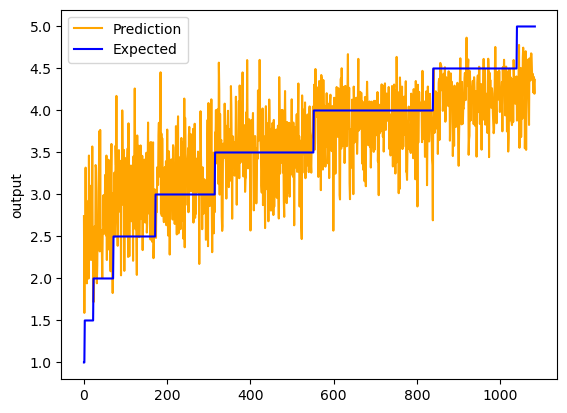

641. The Wine Tap JRoY9Mx2LghIki2Uo1SOJA: rating: 3.5, predicted rating: [3.505331]
24. Lafitte's Landing Seafood House Si6LXSR9gvAbmgO5DzV2cw: rating: 4.0, predicted rating: [3.2926571]
445. Miami's Best Cuban By Los Maruchos xqEX7nzaESYmwyS5f_UI9g: rating: 4.0, predicted rating: [4.284328]
903. The Woodrack Cafe dcpWZ6Yk_S0HqTlNBi8jiA: rating: 4.0, predicted rating: [3.7831178]
249. Kroger cogiJiOXN5fDu7jnkYEkfQ: rating: 4.0, predicted rating: [4.293975]


In [4]:
# Finding the Best Model:
# Testing with:
# Activation: relu, sigmoid, tanh 
# Number of layers and neuron count for each layer 
# Optimizer: adam and sgd.

from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import random
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import os
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers


model_dir = "models"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Set path and preprocess for functions
path = "./yelp_dataset/"

#Set paths for JSON
review_Path = os.path.join(path,"yelp_academic_dataset_review.json")
business_Path = os.path.join(path,"yelp_academic_dataset_business.json")

# Read JSON data and drop businesses with less than 20 reviews
review_df = pd.read_json(review_Path, lines=True, nrows = 100000)
all_business_df = pd.read_json(business_Path, lines=True, nrows = 100000)
business_df = all_business_df[all_business_df['review_count'] >= 20]

#You may use the following code to group ALL the reviews by each business and create a new
#dataframe, where each line is a business with all its reviews aggregated together. From there,
#you then use tfidfVectorzier to obtain TFIDF representation for each business.
df_review_agg = review_df.groupby('business_id')['text'].sum()
df_ready_to_be_sent_to_sklearn = pd.DataFrame({'business_id': df_review_agg.index,
                                               'all_reviews': df_review_agg.values,})

#Create table with ID, stars, and all reviews in one table then change 'stars' since this is already a col on tfidf
business_subset = business_df[['business_id', 'stars']]
review_subset = df_ready_to_be_sent_to_sklearn[['business_id', 'all_reviews']]
merged_df = pd.merge(business_subset, df_ready_to_be_sent_to_sklearn, on='business_id', how='inner')
merged_df.rename(columns={'stars': 'stars_for_model'}, inplace=True)

# Initialize the tfidf Vectorizer and set max features and stop words
tfidf = TfidfVectorizer(max_features=4000,stop_words="english")

# Transform all_reviews and turn into a matrix
tfidf_matrix = tfidf.fit_transform(merged_df['all_reviews'])

# Turn the matrix into a dataframe where the cols are all the words. Then add the stars into the dataframe for model to use and use to_xy for tensorflow to read
tfidf_df = pd.DataFrame(data = tfidf_matrix.toarray(), columns = tfidf.get_feature_names_out())
tfidf_df = pd.concat([merged_df['stars_for_model'], tfidf_df] , axis=1)
x,y = to_xy(tfidf_df,'stars_for_model')

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

# Define hyperparameters that were requested
activations = ['relu', 'sigmoid', 'tanh']
layer_neurons = [[100, 50], [100, 50, 25], [150, 75, 30], [100, 100, 100], [150, 100, 75, 50, 25]]  # Different layer configurations
optimizers = ['adam', 'sgd']

def Model_Test(activation, layer_neurons, optimizer):
    model = Sequential()
    model.add(Dense(layer_neurons[0], input_dim=x_train.shape[1], activation=activation))
    model.add(Dropout(0.1))
    for n in layer_neurons[1:]:
        model.add(Dense(n, activation=activation))
        model.add(Dropout(0.1))
    model.add(Dense(1, activation ='linear'))
    model.compile(loss='mean_squared_error', optimizer = optimizer)
    return model

best_rmse = float('inf')
best_model = None
best_params = {}

results = []

for activation in activations:
    for neurons in layer_neurons:
        for optimizer in optimizers:
            model = Model_Test(activation, neurons, optimizer)

            #
            monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto')
            model_filename = f"model_{activation}_{neurons}_{optimizer}.keras"
            checkpointer = ModelCheckpoint(filepath=model_filename, verbose=0, save_best_only=True) # save best model

            # batch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32.
            model.fit(x_train,y_train,validation_data=(x_test,y_test), batch_size= 32, callbacks=[monitor,checkpointer],verbose=2,epochs=1000)

            #
            model.load_weights(model_filename)

            # Predict and measure RMSE
            pred = model.predict(x_test)
            print(pred)
            score = np.sqrt(metrics.mean_squared_error(pred,y_test))
            print("Score (RMSE): {}".format(score))

            # Store results
            results.append({
                'Activation': activation,
                'Neurons': str(neurons),
                'Optimizer': optimizer,
                'RMSE': score
            })

            if score < best_rmse:
                best_rmse = score
                best_model = model
                best_params = {
                    'Activation': activation,
                    'Neurons': neurons,
                    'Optimizer': optimizer,
                    'RMSE': best_rmse
                }

# Table of Results
results_df = pd.DataFrame(results)
print(results_df)

print("\nBest Combination:")
print(best_params)

# Plot the chart without Rounding & RMSE
pred = best_model.predict(x_test)

score = np.sqrt(metrics.mean_squared_error(pred, y_test))
print("Score (RMSE) without Rounding: {}".format(score))
chart_regression(pred.flatten(), y_test)

# Displaying 5 Businesses Randomly

# Merged df to connect business names back to the star ratings
merged_name_star = pd.merge(business_names, merged_df, on='business_id', how='inner')
businesses = merged_name_star['name']
b_id = merged_name_star['business_id']

# Specific data prediction for 5 businesses
for i in range(5):
    j = random.randint(0, (y_test.size) - 1)
    print("{}. {} {}: rating: {}, predicted rating: {}".format(j+1, businesses[j], b_id[j], y_test[j], pred[j]))

Score (RMSE) with Rounding: 0.5588106513023376


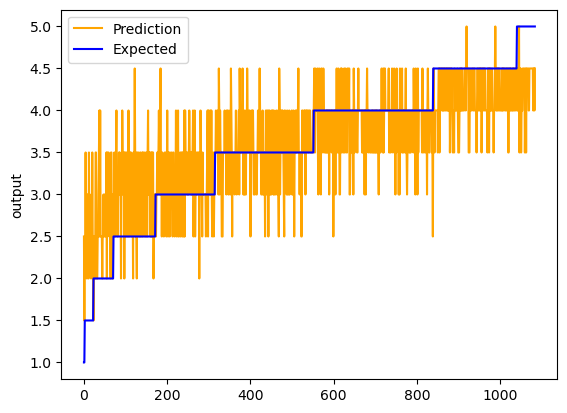

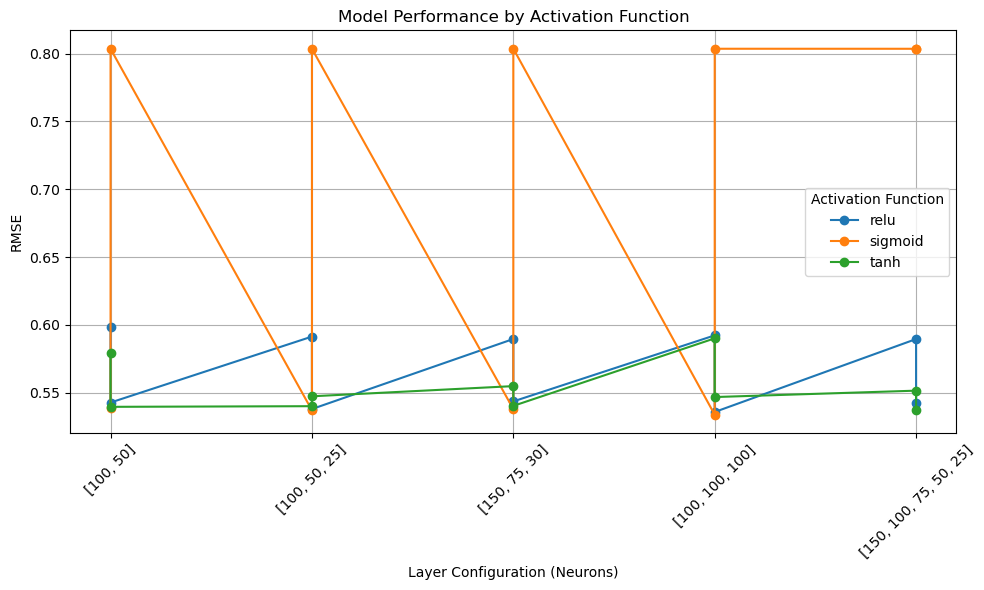

In [5]:

# Rounding up predicted values to .5
for i in pred:
    if i[0] < 5:
        i[0] = round(i[0]*2)/2
    if i[0] > 5:
        i[0] = 5

# Plot the chart with Rounding & RMSE
score2 = np.sqrt(metrics.mean_squared_error(pred, y_test))
print("Score (RMSE) with Rounding: {}".format(score2))
chart_regression(pred.flatten(), y_test)

plot(results_df)

### Additional Feature: Different Review Counts
- This tests if changing the minimum review count for a business to qualify would change the RMSE
- Conclusion: Excluding businesses with less reviews lends to a better Model, with a lower RMSE

REG


c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
52/52 - 8s - 156ms/step - loss: 5.2858 - val_loss: 1.4428
Epoch 2/1000
52/52 - 1s - 13ms/step - loss: 0.8898 - val_loss: 0.7150
Epoch 3/1000
52/52 - 1s - 12ms/step - loss: 0.4469 - val_loss: 0.4282
Epoch 4/1000
52/52 - 1s - 11ms/step - loss: 0.2823 - val_loss: 0.3711
Epoch 5/1000
52/52 - 0s - 9ms/step - loss: 0.2130 - val_loss: 0.3387
Epoch 6/1000
52/52 - 1s - 13ms/step - loss: 0.1646 - val_loss: 0.3216
Epoch 7/1000
52/52 - 0s - 9ms/step - loss: 0.1329 - val_loss: 0.3255
Epoch 8/1000
52/52 - 0s - 9ms/step - loss: 0.1250 - val_loss: 0.3193
Epoch 9/1000
52/52 - 1s - 12ms/step - loss: 0.1347 - val_loss: 0.3553
Epoch 10/1000
52/52 - 1s - 13ms/step - loss: 0.1123 - val_loss: 0.3205
Epoch 11/1000
52/52 - 1s - 14ms/step - loss: 0.1002 - val_loss: 0.3270
Epoch 12/1000
52/52 - 0s - 9ms/step - loss: 0.0915 - val_loss: 0.3337
Epoch 13/1000
52/52 - 0s - 8ms/step - loss: 0.0912 - val_loss: 0.3365
Epoch 14/1000
52/52 - 0s - 9ms/step - loss: 0.0910 - val_loss: 0.3175
Epoch 15/1000
52/52 

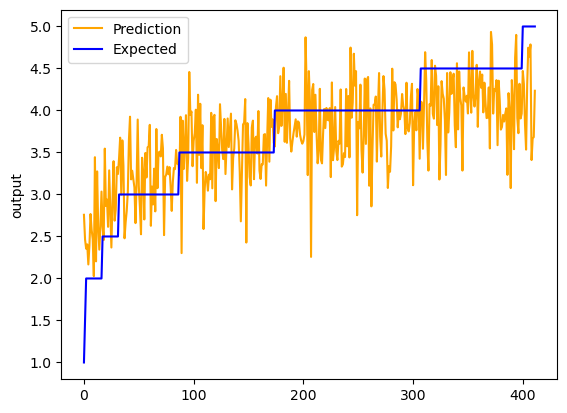

In [6]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import random
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import os
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

# Changing Minimum Review Count to 70

# Set path and preprocess for functions
path = "./yelp_dataset/"
preprocess = True

#Set paths for JSON
review_Path = os.path.join(path,"yelp_academic_dataset_review.json")
business_Path = os.path.join(path,"yelp_academic_dataset_business.json")

# Read JSON data and drop businesses with less than 70 reviews
review_df = pd.read_json(review_Path, lines=True, nrows = 100000)
all_business_df = pd.read_json(business_Path, lines=True, nrows = 100000)
business_df = all_business_df[all_business_df['review_count'] >= 70]

#You may use the following code to group ALL the reviews by each business and create a new
#dataframe, where each line is a business with all its reviews aggregated together. From there,
#you then use tfidfVectorzier to obtain TFIDF representation for each business.
df_review_agg = review_df.groupby('business_id')['text'].sum()
df_ready_to_be_sent_to_sklearn = pd.DataFrame({'business_id': df_review_agg.index,
                                               'all_reviews': df_review_agg.values,})

#Create table with ID, stars, and all reviews in one table then change 'stars' since this is already a col on tfidf
business_subset = business_df[['business_id', 'stars']]
business_names = business_df[['name', 'business_id']]
review_subset = df_ready_to_be_sent_to_sklearn[['business_id', 'all_reviews']]
merged_df = pd.merge(business_subset, review_subset, on='business_id', how='inner')
merged_df.rename(columns={'stars': 'stars_for_model'}, inplace=True)

# Initialize the tfidf Vectorizer and set max features and stop words
tfidf = TfidfVectorizer(max_features=4000,stop_words="english")

# Transform all_reviews and turn into a matrix
tfidf_matrix = tfidf.fit_transform(merged_df['all_reviews'])

# Turn the matrix into a dataframe where the cols are all the words. Then add the stars into the dataframe for model to use and use to_xy for tensorflow to read
tfidf_df = pd.DataFrame(data = tfidf_matrix.toarray(), columns = tfidf.get_feature_names_out())
tfidf_df = pd.concat([merged_df['stars_for_model'], tfidf_df] , axis=1)
x,y = to_xy(tfidf_df,'stars_for_model')

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

#Run the model 5 times to ensure best model is found
i = 0
while (i < 5):
    model = Sequential()
    model.add(Dense(100, input_dim=x.shape[1], activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(50, input_dim=x.shape[1], activation='relu')) 
    model.add(Dropout(0.1))
    model.add(Dense(25, input_dim=x.shape[1], activation='relu')) 
    model.add(Dense(1, activation='linear'))

    adam = optimizers.Adam(learning_rate=0.001, beta_1=0.999, beta_2=0.999, epsilon=None, amsgrad=False)
    model.compile(loss='mean_squared_error', optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto')
    checkpointer = ModelCheckpoint(filepath="dnn/yelp.keras", verbose=0, save_best_only=True) # save best model

    # batch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32.
    model.fit(x_train, y_train, validation_data=(x_test,y_test), batch_size= 32, callbacks=[monitor,checkpointer], verbose=2, epochs=1000)
    i = i+1

model.load_weights('dnn/yelp.keras') # load weights from best model

# Predict and measure RMSE
pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

# Merged df to connect business names back to the star ratings
merged_name_star = pd.merge(business_names, merged_df, on='business_id', how='inner')
businesses = merged_name_star['name']
b_id = merged_name_star['business_id']

# Specific data prediction for 5 businesses
for i in range(5):
    j = random.randint(0, (y_test.size) - 1)
    print("{}. {} {}: rating: {}, predicted rating: {}".format(j+1, businesses[j], b_id[j], y_test[j], pred[j]))

# Plot the chart
chart_regression(pred.flatten(),y_test)


REG


c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
49/49 - 5s - 96ms/step - loss: 4.7623 - val_loss: 1.1289
Epoch 2/1000
49/49 - 0s - 9ms/step - loss: 0.9108 - val_loss: 0.5769
Epoch 3/1000
49/49 - 0s - 9ms/step - loss: 0.4578 - val_loss: 0.3496
Epoch 4/1000
49/49 - 0s - 10ms/step - loss: 0.2539 - val_loss: 0.3092
Epoch 5/1000
49/49 - 0s - 10ms/step - loss: 0.1900 - val_loss: 0.2853
Epoch 6/1000
49/49 - 0s - 10ms/step - loss: 0.1466 - val_loss: 0.2636
Epoch 7/1000
49/49 - 0s - 8ms/step - loss: 0.1349 - val_loss: 0.2702
Epoch 8/1000
49/49 - 0s - 9ms/step - loss: 0.1077 - val_loss: 0.2854
Epoch 9/1000
49/49 - 1s - 11ms/step - loss: 0.1140 - val_loss: 0.2763
Epoch 10/1000
49/49 - 0s - 10ms/step - loss: 0.0994 - val_loss: 0.2908
Epoch 11/1000
49/49 - 0s - 8ms/step - loss: 0.0948 - val_loss: 0.2840
Epoch 12/1000
49/49 - 0s - 9ms/step - loss: 0.0848 - val_loss: 0.2780
Epoch 13/1000
49/49 - 0s - 8ms/step - loss: 0.0805 - val_loss: 0.2863
Epoch 14/1000
49/49 - 0s - 8ms/step - loss: 0.0773 - val_loss: 0.2935
Epoch 15/1000
49/49 - 0

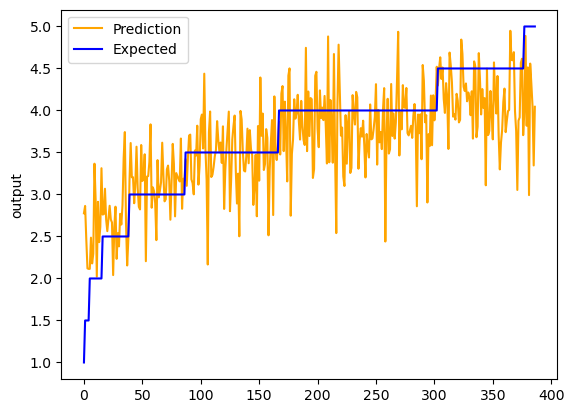

In [7]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import random
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import os
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

# Changing Minimum Review Count to 75

# Set path and preprocess for functions
path = "./yelp_dataset/"
preprocess = True

#Set paths for JSON
review_Path = os.path.join(path,"yelp_academic_dataset_review.json")
business_Path = os.path.join(path,"yelp_academic_dataset_business.json")

# Read JSON data and drop businesses with less than 75 reviews
review_df = pd.read_json(review_Path, lines=True, nrows = 100000)
all_business_df = pd.read_json(business_Path, lines=True, nrows = 100000)
business_df = all_business_df[all_business_df['review_count'] >= 75]

#You may use the following code to group ALL the reviews by each business and create a new
#dataframe, where each line is a business with all its reviews aggregated together. From there,
#you then use tfidfVectorzier to obtain TFIDF representation for each business.
df_review_agg = review_df.groupby('business_id')['text'].sum()
df_ready_to_be_sent_to_sklearn = pd.DataFrame({'business_id': df_review_agg.index,
                                               'all_reviews': df_review_agg.values,})

#Create table with ID, stars, and all reviews in one table then change 'stars' since this is already a col on tfidf
business_subset = business_df[['business_id', 'stars']]
business_names = business_df[['name', 'business_id']]
review_subset = df_ready_to_be_sent_to_sklearn[['business_id', 'all_reviews']]
merged_df = pd.merge(business_subset, review_subset, on='business_id', how='inner')
merged_df.rename(columns={'stars': 'stars_for_model'}, inplace=True)

# Initialize the tfidf Vectorizer and set max features and stop words
tfidf = TfidfVectorizer(max_features=4000,stop_words="english")

# Transform all_reviews and turn into a matrix
tfidf_matrix = tfidf.fit_transform(merged_df['all_reviews'])

# Turn the matrix into a dataframe where the cols are all the words. Then add the stars into the dataframe for model to use and use to_xy for tensorflow to read
tfidf_df = pd.DataFrame(data = tfidf_matrix.toarray(), columns = tfidf.get_feature_names_out())
tfidf_df = pd.concat([merged_df['stars_for_model'], tfidf_df] , axis=1)
x,y = to_xy(tfidf_df,'stars_for_model')

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

#Run the model 5 times to ensure best model is found
i = 0
while (i < 5):
    model = Sequential()
    model.add(Dense(100, input_dim=x.shape[1], activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(50, input_dim=x.shape[1], activation='relu')) 
    model.add(Dropout(0.1))
    model.add(Dense(25, input_dim=x.shape[1], activation='relu')) 
    model.add(Dense(1, activation='linear'))

    adam = optimizers.Adam(learning_rate=0.001, beta_1=0.999, beta_2=0.999, epsilon=None, amsgrad=False)
    model.compile(loss='mean_squared_error', optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto')
    checkpointer = ModelCheckpoint(filepath="dnn/yelp.keras", verbose=0, save_best_only=True) # save best model

    # batch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32.
    model.fit(x_train, y_train, validation_data=(x_test,y_test), batch_size= 32, callbacks=[monitor,checkpointer], verbose=2, epochs=1000)
    i = i+1

model.load_weights('dnn/yelp.keras') # load weights from best model

# Predict and measure RMSE
pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred, y_test))
print("Score (RMSE): {}".format(score))

# Merged df to connect business names back to the star ratings
merged_name_star = pd.merge(business_names, merged_df, on='business_id', how='inner')
businesses = merged_name_star['name']
b_id = merged_name_star['business_id']

for i in range(5):
    j = random.randint(0, (y_test.size) - 1)
    print("{}. {} {}: rating: {}, predicted rating: {}".format(j+1, businesses[j], b_id[j], y_test[j], pred[j]))

# Plot the chart
chart_regression(pred.flatten(), y_test)


### Additional Feature: Per Category Model
- Groups Businesses by a specified category and creates a model with the affected businesses
- Conclusion: Placing into categories limits the training data and produces a less accurate RMSE

                  business_id                    name               address  \
104    Dy91wdWkwtI_qgjAIZ0Niw     Taqueria Los Primos  3322 Old Capitol Trl   
153    aNtKyc2rr-uK5cqzY9TVQQ  Chipotle Mexican Grill     10160 Ulmerton Rd   
159    X_E7U2lVNEwbH_gpOBmAHQ          Cerveza Jack's         135 2nd Ave N   
278    W57cR9a7XP6RX56MSWHJJA          Las Margaritas      514 S Rampart St   
290    xa6JYHDgVza7CuenKBJBHw       Taqueria El Sitio   3466 A Lebanon Pike   
...                       ...                     ...                   ...   
99919  4E6kHJ7yxDpu43L8he6F7A      La Casita Taqueria           8400 Oak St   
99926  lWnqWDfcISTHnL973Uwplg    Mariscos Las Islitas      1700 S Wells Ave   
99953  vHys_KQJys2bSO2w1_WHrg         Los Tacos Locos         119 S York Rd   
99989  lkAzVdzEZE0jEU91PmvQhQ        Margaritas Grill  3320 Old Capitol Trl   
99993  Z2_-rlxyXQsqcGXChydhlA  La Guera Mexican Grill        132 Garrett Rd   

              city state postal_code   latitude   l

c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
5/5 - 7s - 1s/step - loss: 12.7592 - val_loss: 10.7116
Epoch 2/1000
5/5 - 0s - 58ms/step - loss: 9.5614 - val_loss: 6.9108
Epoch 3/1000
5/5 - 0s - 43ms/step - loss: 5.4481 - val_loss: 2.9258
Epoch 4/1000
5/5 - 0s - 37ms/step - loss: 2.0095 - val_loss: 1.1068
Epoch 5/1000
5/5 - 0s - 24ms/step - loss: 1.7724 - val_loss: 1.8745
Epoch 6/1000
5/5 - 0s - 34ms/step - loss: 2.0286 - val_loss: 1.2107
Epoch 7/1000
5/5 - 0s - 40ms/step - loss: 1.2041 - val_loss: 0.9961
Epoch 8/1000
5/5 - 0s - 25ms/step - loss: 1.0562 - val_loss: 1.1096
Epoch 9/1000
5/5 - 0s - 36ms/step - loss: 1.0137 - val_loss: 0.9801
Epoch 10/1000
5/5 - 0s - 42ms/step - loss: 0.9034 - val_loss: 0.8196
Epoch 11/1000
5/5 - 0s - 40ms/step - loss: 0.6144 - val_loss: 0.7975
Epoch 12/1000
5/5 - 0s - 39ms/step - loss: 0.6144 - val_loss: 0.7486
Epoch 13/1000
5/5 - 0s - 43ms/step - loss: 0.6316 - val_loss: 0.6884
Epoch 14/1000
5/5 - 0s - 56ms/step - loss: 0.4789 - val_loss: 0.6560
Epoch 15/1000
5/5 - 0s - 57ms/step - loss: 

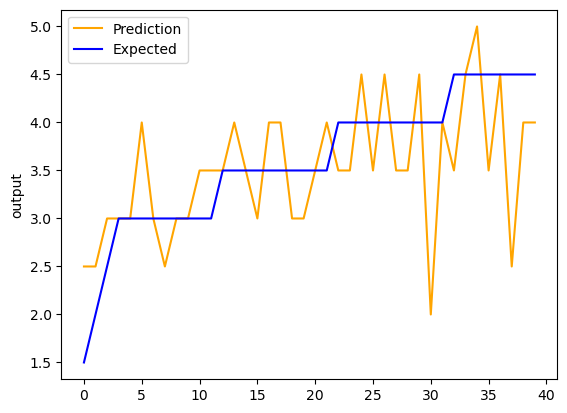

In [9]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import random
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import os
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

# Per Category 
ctgry = 'Mexican'


# Read JSON data and drop businesses with less than 20 reviews
review_df = pd.read_json(review_Path, lines=True, nrows = 100000)
all_business_df_0 = pd.read_json(business_Path, lines=True, nrows = 100000)
b_id = all_business_df[['business_id']]


# Filter to specific category
all_business_df = all_business_df_0[all_business_df_0['categories'].astype(str).str.contains(ctgry)]
print(all_business_df)

# Filter our businesses with less than 20 reviews
business_df = all_business_df[all_business_df['review_count'] >= 50]

#You may use the following code to group ALL the reviews by each business and create a new
#dataframe, where each line is a business with all its reviews aggregated together. From there,
#you then use tfidfVectorzier to obtain TFIDF representation for each business.
df_review_agg = review_df.groupby('business_id')['text'].sum()
df_ready_to_be_sent_to_sklearn = pd.DataFrame({'business_id': df_review_agg.index,
                                               'all_reviews': df_review_agg.values,})

#Create table with ID, stars, and all reviews in one table then change 'stars' since this is already a col on tfidf
business_subset = business_df[['business_id', 'stars']]
business_names = business_df[['name', 'business_id']]
review_subset = df_ready_to_be_sent_to_sklearn[['business_id', 'all_reviews']]
merged_df = pd.merge(business_subset, review_subset, on='business_id', how='inner')
merged_df.rename(columns={'stars': 'stars_for_model'}, inplace=True)

# Initialize the tfidf Vectorizer and set max features and stop words
tfidf = TfidfVectorizer(max_features=4000,stop_words="english")

# Transform all_reviews and turn into a matrix
tfidf_matrix = tfidf.fit_transform(merged_df['all_reviews'])

# Turn the matrix into a dataframe where the cols are all the words. Then add the stars into the dataframe for model to use and use to_xy for tensorflow to read
tfidf_df = pd.DataFrame(data = tfidf_matrix.toarray(), columns = tfidf.get_feature_names_out())
tfidf_df = pd.concat([merged_df['stars_for_model'], tfidf_df] , axis=1)
x,y = to_xy(tfidf_df,'stars_for_model')

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

#Run the model 5 times to ensure best model is found
i = 0
while (i < 5):
    model = Sequential()
    model.add(Dense(100, input_dim=x.shape[1], activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(50, input_dim=x.shape[1], activation='relu')) 
    model.add(Dropout(0.1))
    model.add(Dense(25, input_dim=x.shape[1], activation='relu')) 
    model.add(Dense(1, activation='linear'))

    adam = optimizers.Adam(learning_rate=0.001, beta_1=0.999, beta_2=0.999, epsilon=None, amsgrad=False)
    model.compile(loss='mean_squared_error', optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto')
    checkpointer = ModelCheckpoint(filepath="dnn/yelp.keras", verbose=0, save_best_only=True) # save best model

    # batch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32.
    model.fit(x_train, y_train, validation_data = (x_test, y_test), batch_size= 32, callbacks=[monitor,checkpointer], verbose=2, epochs=1000)
    i = i+1

model.load_weights('dnn/yelp.keras') # load weights from best model

# Predict and measure RMSE
pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred, y_test))
print("Score (RMSE) wihtout Rounding: {}".format(score))

# Merged df to connect business names back to the star ratings
merged_name_star = pd.merge(business_names, merged_df, on='business_id', how='inner')
businesses = merged_name_star['name']
b_id = merged_name_star['business_id']

# Specific data prediction for 5 businesses
for i in range(5):
    j = random.randint(0, (y_test.size) - 1)
    print("{}. {} {}: rating: {}, predicted rating: {}".format(j+1, businesses[j], b_id[j], y_test[j], pred[j]))

# Rounding up predicted values to .5
for i in pred:
    if i[0] < 5:
        i[0] = round(i[0]*2)/2 

score = np.sqrt(metrics.mean_squared_error(pred, y_test))
print("Score (RMSE) with Rounding: {}".format(score))

# Plot the chart
chart_regression(pred.flatten(), y_test)
